In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
#from statannotations.Annotator import Annotator #https://github.com/trevismd/statannotations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# if getting OptionError: "No such keys(s): 'mode.use_inf_as_null'"
# !pip install --upgrade seaborn pandas

import os
from glob import glob

if not os.path.exists('../paper/figs'):
    os.makedirs('../paper/figs')

from _load_data import * # Getting our specific labels, formatting, and data

# Getting some free samples
results_df.sample(3)

print(gens)

# Don't change any code below, it may break (probably will) --------------------

['../models/SimplifierTopDown.py', '../models/SimplifierTopDownOnlyLast.py', '../models/SimplifierBottomUp.py', '../models/Vanilla.py', '../models/SimplifierBottomUpOnlyLast.py'] ['Top Down', 'Top Down (only last)', 'Bottom Up', 'Without simplify', 'Bottom Up (only last)']
(300, 14)
['Top Down' 'Top Down (only last)' 'Bottom Up' 'Without simplify'
 'Bottom Up (only last)']
['Airfoil' 'Concrete' 'Energy Cooling' 'Energy Heating' 'Housing' 'Tower']
[10, 20, 30, 40, 50, 60, 70, 80, 90, 99]


,model,dataset,delta
0,Bottom Up,Airfoil,-146.153846
1,Bottom Up,Airfoil,14.285714
2,Bottom Up,Airfoil,56.250000
3,Bottom Up,Airfoil,-30.000000
4,Bottom Up,Airfoil,-44.444444
...,...,...,...
295,Without simplify,Tower,0.000000
296,Without simplify,Tower,0.000000
297,Without simplify,Tower,0.000000
298,Without simplify,Tower,0.000000


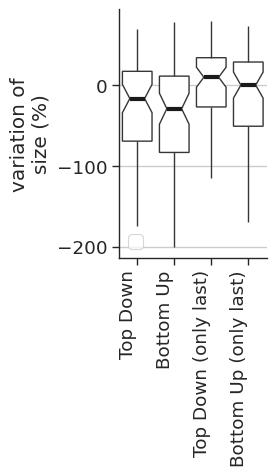

,model,dataset,delta
0,Bottom Up,Airfoil,0.438440
1,Bottom Up,Airfoil,-2.911298
2,Bottom Up,Airfoil,62.822485
3,Bottom Up,Airfoil,2693.950665
4,Bottom Up,Airfoil,151.462441
...,...,...,...
295,Without simplify,Tower,0.000000
296,Without simplify,Tower,0.000000
297,Without simplify,Tower,0.000000
298,Without simplify,Tower,0.000000


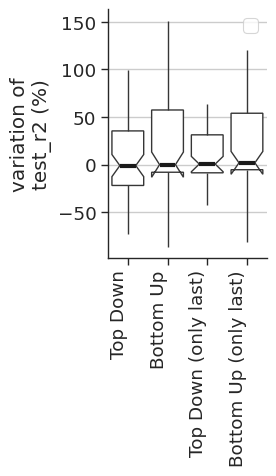

,model,dataset,delta
0,Bottom Up,Airfoil,8.209957
1,Bottom Up,Airfoil,3.204589
2,Bottom Up,Airfoil,-44.759376
3,Bottom Up,Airfoil,-62.644602
4,Bottom Up,Airfoil,-18.697590
...,...,...,...
295,Without simplify,Tower,0.000000
296,Without simplify,Tower,0.000000
297,Without simplify,Tower,0.000000
298,Without simplify,Tower,0.000000


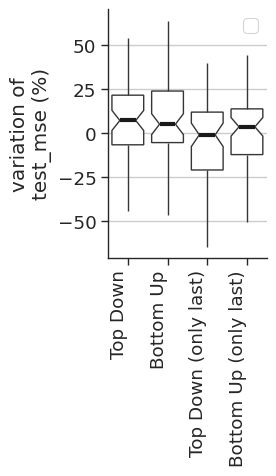

In [2]:
baseline_convergence = (results_df.loc[results_df['model'] == 'Without simplify'].groupby(['dataset', 'random_state']))

for metric in ['size', 'test_r2', 'test_mse']:
    speeds    = []
    for (model, dataset, random_state), group_df in \
        results_df.loc[results_df['model'] != 'Baseline'].groupby(['model', 'dataset', 'random_state']):
        # 'contextual' is used as a hue in the plots

        baseline_curve = baseline_convergence.get_group((dataset, random_state))
        
        metric_baseline = baseline_curve[metric].values[0]
        metric_model = group_df[metric].values[0]
        speeds.append( (model, dataset, (metric_model-metric_baseline)*100/metric_model) )

    speeds_df = pd.DataFrame(data=speeds, columns=['model', 'dataset', 'delta'])
    display(speeds_df)
    g=sns.catplot( data=speeds_df, y=f'delta', x='model', 
        #col='dataset', col_wrap=col_wrap, # remove col to aggregate all speed ups into one plot
        legend_out=False, aspect=0.6,
        order = [o for o in order if o != 'Without simplify'], # The first is Baseline
        **boxplot_kwargs, sharey=False
    )

    # g.set(yscale="log")

    g.set_titles("{col_name}").set_axis_labels("", f"variation of\n{metric} (%)")

    # iterate through each subplot / Facet
    single_plot = True
    for (ds, plot_ax) in g._axes_dict.items():
        single_plot = False
        plot_ax.grid(which='major', axis='y', linewidth=1)
        #plot_ax.axhline(100.0, c='k', zorder=-999, linewidth=1.5)
        
        for tick in plot_ax.get_xticklabels():
            tick.set(rotation=90, ha="right")

        # Contextual vs non-contextual
        pairs = [('D-TS', 'C-D-TS'), ('D-UCB1', 'C-D-UCB1')]

        if False:
            annotator = Annotator(
                plot_ax, pairs, data=speeds_df[(speeds_df['dataset']==ds)],
                x='model', y='Speed up',
                order=order[1:])
            annotator.reset_configuration()
            annotator.configure(test="Mann-Whitney", hide_non_significant=True, #text_format='full',
                                comparisons_correction="holm", verbose=1, text_offset=-3)
            
            # Calculate and annotate
            annotator.apply_and_annotate()
            
    if single_plot: 
        g.ax.grid(which='major', axis='y', linewidth=1)
        #g.ax.axhline(1.0, c='k', zorder=-999, linewidth=1.5)
        
        for tick in g.ax.get_xticklabels():
            tick.set(rotation=90, ha="right")

    plt.tight_layout()
    plt.savefig(f"../paper/figs/delta_{metric}.pdf")
    plt.savefig(f"../paper/figs/delta_{metric}.png")
    plt.show()